In [2]:
import gym
import logging
import numpy as np
import dill as pickle
import os

from threading import Thread, Lock
from time import sleep
from client import CarDirection, Client
from env import JunctionEnvironment
from matplotlib import pyplot as plt
from alg_astar import *

%load_ext autoreload
%autoreload 2

In [3]:
logger = logging.getLogger(None)
logger.setLevel(logging.WARNING)

In [4]:
team_name = "ipa"
team_key = "admin"
N_GAMES = 1
CACHE_DIR = "./cache"
DATASET_DIR = os.path.join(CACHE_DIR, "dataset")
IMIT_LEARNING_DATASET_DIR = os.path.join(DATASET_DIR, "imitation_learning")

if not os.path.isdir(IMIT_LEARNING_DATASET_DIR):
    os.makedirs(IMIT_LEARNING_DATASET_DIR)

In [5]:
def center_pad_observations(obs, receptor_size=100):
    npad_ = (receptor_size-obs.shape[1])//2 # make sure the receptive field is always 200
    npads = ((0, 0), (npad_, npad_), (npad_, npad_), (0, 0))
    return np.pad(obs, pad_width=npads, mode='constant', constant_values=0)

In [6]:
class Runner(Thread):
    def __init__(self, car_id, capacity, capacity_limit, game_id, env, lock):
        super().__init__()
        self.car_id = car_id
        self.capacity = capacity
        self.capacity_limit = capacity_limit
        self.game_id = game_id
        self.env = env
        self.lock = lock
        
        self.prev_obs = None
        
        self.obss = []
        self.scores = []
        self.actions = []
        
        self.current_target = None


    def megaalg(self, obs):
        car_x, car_y = np.where(obs[:,:,4])[0][0], np.where(obs[:,:,4])[1][0]
        
        maze = 1-obs[:,:,0]
        
        possible_targets = []
        possible_targets_paths = []
        target_cell = None

        if self.current_target is None:
            # no target
            print('no target')
            if obs[:,:,3].sum() > 0:
                # go to destination
                print('Checking destinations')
                destinations = np.where(obs[:,:,3])
                for i in range(len(destinations[0])):
                    x, y = destinations[0][i], destinations[1][i]
                    path, status = search(maze, 1, (car_x, car_y), (x ,y))
                    if path is not None:
                        possible_targets.append((x,y))
                        possible_targets_paths.append(path)  
            
            capacity = obs[0,0,5]
            print(capacity, self.capacity_limit)
            if capacity > 0 and obs[:,:,1].sum()>0:
                # pick up a client
                print('Checking clients')
                coords = np.where(obs[:,:,1])
                for i in range(len(coords[0])):
                    x, y = coords[0][i], coords[1][i]
                    #customer_positions.append((x,y))
                    dist = np.abs(car_x - x) + np.abs(car_y - y)
                    #customer_dists.append(dist)
                    if dist < 50:
                        path, status = search(maze, 1, (car_x, car_y), (x, y))
                        if path is not None and len(path) < 50:
                            possible_targets.append((x,y))
                            possible_targets_paths.append(path)
                        
            print('len possible targets:',len(possible_targets_paths))

            if len(possible_targets_paths)>0:
                #print(possible_targets)
                min_path = min([x for x in possible_targets_paths if len(x)>0], key = lambda p: len(p))
                self.current_target = min_path[-1]
                target_cell = min_path[0]
        else:
            # target is known
            x, y = self.current_target
            #print(car_x, car_y)
            path, _ = search(maze, 1, (car_x, car_y), (x ,y))
            if not path:
                self.current_target = None
                return 4
            if len(path)==1:
                self.current_target = None
            target_cell = path[0]
            

        #print(target_cell, car_x, car_y)
        if target_cell is None:
            return 4
        if target_cell[0] == car_x and target_cell[1] == car_y - 1:
            #return 3
            return 3
        if target_cell[0] == car_x and target_cell[1] == car_y + 1:
            #return 1
            return 1
        if target_cell[0] == car_x - 1 and target_cell[1] == car_y:
            #return 2
            return 2
        if target_cell[0] == car_x + 1 and target_cell[1] == car_y:
            #return 0
            return 0
        return 4

        
    def run(self):
        # Need to do some initial action to fetch observations
        obs, score, done, _ = self.env.step(1, self.car_id)
        self.prev_obs = obs
        
        while True:
            try:
                new_action = self.megaalg(self.prev_obs)
                self.lock.acquire()
                print(new_action)
                obs, score, done, _ = self.env.step(new_action, self.car_id)
                # print(score, done)
            except Exception as ex:
                # print(f"{self.car_id}: {ex}")
                raise ex
            finally:
                try:
                    self.lock.release()
                except:
                    pass
            if done:
                break

            action = new_action

            self.obss.append(self.prev_obs)
            self.scores.append(score)
            self.actions.append(action)

            self.prev_obs = obs                
           # sleep(0.5)
           
        
        self.obss = np.array(self.obss)
        self.scores = np.array(self.scores)
        self.actions = np.array(self.actions)
        
        with open(os.path.join(IMIT_LEARNING_DATASET_DIR, f"game_{self.game_id}_car_{self.car_id}_obs.pkl"), "wb") as f:
            pickle.dump(self.obss, f)
        with open(os.path.join(IMIT_LEARNING_DATASET_DIR, f"game_{self.game_id}_car_{self.car_id}_scores.pkl"), "wb") as f:
            pickle.dump(self.scores, f)
        with open(os.path.join(IMIT_LEARNING_DATASET_DIR, f"game_{self.game_id}_car_{self.car_id}_actions.pkl"), "wb") as f:
            pickle.dump(self.actions, f)
        print(f"{self.car_id} finished")

In [7]:
game_ids = []

if __name__ == "__main__":
    print("In main thread")
    client = Client(team_name=team_name, team_key=team_key)
    env = JunctionEnvironment(client)

    lock = Lock()

    for i in range(N_GAMES):
        print("Running game", i)
        game_id = np.random.randint(0, 100000)
        _ = env.reset()

        processes = []
        print(env.car_ids, env.capacity, env.capacity_limit)
        for car_id in env.car_ids:
            process = Runner(car_id, env.capacity[car_id], env.capacity_limit[car_id], game_id, env, lock)
            processes.append(process)
            

        for process in processes:
            process.start()

        for process in processes:
            process.join()
        print(f"Game {i} finished")
        game_ids.append(game_id)

In main thread
Running game 0
['0', '1', '2'] {'0': 0, '1': 0, '2': 0} {'0': 2, '1': 2, '2': 2}
no target
no target
2.0 2
Checking clients
no target
2.0 2
Checking clients
2.0 2
Checking clients
len possible targets: 20
1
len possible targets: 20
len possible targets: 19
1
3
1
1
3
1
1
2
no target
Checking destinations
1.0 2
Checking clients
len possible targets: 20
1
2
no target
Checking destinations
1.0 2
Checking clients
len possible targets: 19
2
3
2
2
3
2
3
3no target
2.0 2
Checking clients

len possible targets: 18
2
2
3
2
2
3
3
2
2
3
2
3
3
2
2
3
3no target

Checking destinations
0.0 2
len possible targets: 2
2
1
3
2
1
3
2
1
no target
Checking destinations
0.0 2
len possible targets: 2
3
3
1
3
3
no target
2.0 2
Checking clients
len possible targets: 16
1
0
3
2
2
3
2
0
3
1
0
3
1
3
3
1
3
3
1
3
3
0
3
no target
Checking destinations
1.0 2
Checking clients
len possible targets: 18
3
0
2
3
0
2
3
3
3
3
0
3
3
no target
Checking destinations
giving up on pathfinding too many iterations
1.0

Exception in thread Thread-6:
Traceback (most recent call last):
  File "C:\Users\Alina\Anaconda3\lib\threading.py", line 917, in _bootstrap_inner
    self.run()
  File "<ipython-input-6-346450997314>", line 111, in run
    raise ex
  File "<ipython-input-6-346450997314>", line 104, in run
    new_action = self.megaalg(self.prev_obs)
  File "<ipython-input-6-346450997314>", line 55, in megaalg
    if len(path) < 50:
TypeError: object of type 'NoneType' has no len()



0
0
0
0
1
0
0
0
0
1
0
1
0
1
3
no target
Checking destinations
0.0 2
len possible targets: 2
1
3
1
0
1
3
1
0
1
3
1
0
1
3
1
0
1
0
1
1
giving up on pathfinding too many iterations
0
1
1
giving up on pathfinding too many iterations
0
1
2
0
1
0
2
0
1
0
1
0
2
no target
Checking destinations
1.0 2
Checking clients
len possible targets: 18
3
1
3
0
3
1
3
0
3
1
2
1
2
1
2
1
no target
Checking destinations
0.0 2
len possible targets: 2
2
1
3
1
3
0
0
1
no target
Checking destinations
1.0 2
Checking clients
giving up on pathfinding too many iterations
len possible targets: 18
3
0
0
1
3
0
3
1
no target
0Checking destinations

1.0 2
Checking clients
len possible targets: 17
3
3
2
2
3
0
3
0
2
3
2
3
3
3
3
3
3no target
Checking destinations

0.0 2
len possible targets: 2
1
3
1
0
0
no target
Checking destinations
0.0 2
len possible targets: 2
0
0
0
3
0
0
0
3
0
0
0
0
0
1
0
1
0
1
0
1
0no target
2.0 2
Checking clients

len possible targets: 18
3
0
3
0
3
0
3
0
3
0
3
1
3
no target1
Checking destinations

1.0 2

In [7]:
import glob
import pickle

# get all car data and append it
obs = np.empty((0,100,100,8), dtype=np.int8) # specify the size of the channels
actions = np.empty((0))
scores = np.empty((0))

# Load and concat
for data_type in ["obs", "actions", "scores"]:
    for game_id in game_ids:
        file_names = glob.glob(os.path.join(IMIT_LEARNING_DATASET_DIR, 'game_{0}_car_*_{1}.pkl'.format(game_id, data_type)))
        for f_name in file_names:
            with open(f_name, 'rb') as f:
                data = pickle.load(f)
            if data_type == "obs":
                data = center_pad_observations(data, receptor_size=100)
                obs = np.array(np.append(obs, data, axis=0), dtype=np.int8)
            if data_type == "actions":
                actions = np.append(actions, data, axis=0)
            if data_type == "scores":
                scores = np.append(scores, data, axis=0)
    print("finished appending ", data_type)

if False:
    # save the concated all data              
    with open(os.path.join(IMIT_LEARNING_DATASET_DIR, 'obs_all.pkl'), 'wb') as f:
        print("obs shape: ", obs.shape)
        pickle.dump(obs, f)

    with open(os.path.join(IMIT_LEARNING_DATASET_DIR, 'actions_all.pkl'), 'wb') as f:
        print("actions shape: ", actions.shape)
        pickle.dump(actions, f)

    with open(os.path.join(IMIT_LEARNING_DATASET_DIR, 'scores_all.pkl'), 'wb') as f:
        print("scores shape: ", scores.shape)
        pickle.dump(scores, f)

finished appending  obs
finished appending  actions
finished appending  scores


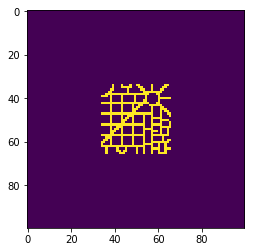

In [10]:
plt.imshow(obs[0,:,:,0])

In [ ]:
game_id

In [8]:
np.max(scores)

-6.0

In [10]:
scores[-1]

-902.0

In [9]:
len(scores)

916